# 2.2 Assignment — TF-IDF vs BoW

**Goal:** 
Compare CountVectorizer (BoW) vs TfidfVectorizer on the same classifier (Logistic Regression)

-I will be using the ham-spam dataset.

## I will:
1. Load and clean the dataset
2. Preprocess text (lowercase, remove punctuation, remove stopwords)
3. Build two feature matrices (BoW and TF-IDF)
4. Train the same model on both
5. Compare metrics and write short reflections

## Imports

In [175]:
import re
import string
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

## Load the dataset

In [178]:
# Preferred - relative path
relative_csv_path = Path("ham-spam.csv")

# Fallback - your provided absolute path
fallback_absolute_path = Path(r"C:\Users\MasterDanteDev86\Downloads\CAP355-O Natural Language Processing - Online\W1\NLP\data\ham-spam.csv")

if relative_csv_path.exists():
    csv_path = relative_csv_path
else:
    csv_path = fallback_absolute_path

print("Loading from:", csv_path)

df = pd.read_csv(csv_path)
df.head()

Loading from: C:\Users\MasterDanteDev86\Downloads\CAP355-O Natural Language Processing - Online\W1\NLP\data\ham-spam.csv


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Quick checks (columns, missing values, class balance)

In [181]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())

print("\nClass counts:\n", df["label"].value_counts())

Shape: (5572, 2)
Columns: ['label', 'text']

Missing values:
 label    0
text     0
dtype: int64

Class counts:
 label
ham     4825
spam     747
Name: count, dtype: int64


## Simple class distribution plot (quick visual check)

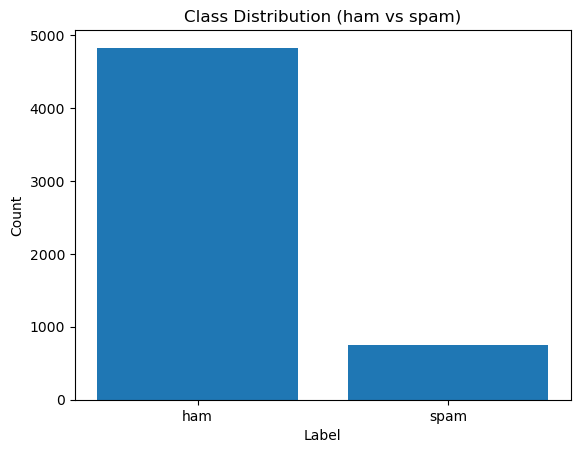

In [184]:
counts = df["label"].value_counts()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class Distribution (ham vs spam)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## Text cleaning and preprocessing:

1. Converts to lowercase
2. Removes stopwords
3. Removes punctuation

## The approach:
1. Lowercase
2. Wil replace punctuation with spaces
3. Will keep only: (letters, numbers, spaces)
4. Will remove stopwords
5. Will collapse extra spaces

In [187]:
stop_words_set = set(ENGLISH_STOP_WORDS)

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Removes punctuation and replace with spaces
    trans_table = str.maketrans({ch: " " for ch in string.punctuation})
    text = text.translate(trans_table)

    # Removes unusual characters (Will keep letters, digits, spaces)
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    # Split, remove stopwords
    parts = text.split()
    kept = []
    for word in parts:
        if word not in stop_words_set:
            kept.append(word)

    cleaned = " ".join(kept)

    # Will collapse extra spaces
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned

# Will apply cleaning
df["clean_text"] = df["text"].apply(clean_text)

df[["label", "text", "clean_text"]].head()

,label,text,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah don t think goes usf lives


## Train and test split

1. Will split and reuse the split for both BoW and TF-IDF (Comparison)
2. Will be using `stratify=y` which keeps the ham/spam ratio similar in train and test

In [190]:
X = df["clean_text"].astype(str)
y = df["label"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))
print("\nTrain label counts:\n", y_train.value_counts())
print("\nTest label counts:\n", y_test.value_counts())

Train size: 4457
Test size : 1115

Train label counts:
 label
ham     3859
spam     598
Name: count, dtype: int64

Test label counts:
 label
ham     966
spam    149
Name: count, dtype: int64


## Extraction: BoW - CountVectorizer

1. Will convert messages into (word count vectors)
2. Will also limit highly common words using (max_df) and remove rare words using (min_df)

In [193]:
bow_vectorizer = CountVectorizer(
    min_df=2,
    max_df=0.95
)

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print("BoW train matrix shape:", X_train_bow.shape)
print("BoW test matrix shape :", X_test_bow.shape)

BoW train matrix shape: (4457, 3387)
BoW test matrix shape : (1115, 3387)


## Extraction: TF-IDF - TfidfVectorizer

1. Will use words, but it minimizes words that appear in most messages
2. TF-IDF will sort out words that are commonand not useful

In [196]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF train matrix shape:", X_train_tfidf.shape)
print("TF-IDF test matrix shape :", X_test_tfidf.shape)

TF-IDF train matrix shape: (4457, 3387)
TF-IDF test matrix shape : (1115, 3387)


## Train the classifier on both

1. Will use **Logistic Regression**, which is a common baseline for text classification.
2. The **max_iter** is increased so it merges cleanly

In [199]:
def train_and_evaluate(Xtr, Xte, ytr, yte, model_name):
    model = LogisticRegression(max_iter=2000, random_state=42)
    model.fit(Xtr, ytr)

    preds = model.predict(Xte)

    acc = accuracy_score(yte, preds)
    cm = confusion_matrix(yte, preds, labels=["ham", "spam"])

    print("====================================")
    print(model_name)
    print("Accuracy:", round(acc, 4))
    print("\nClassification Report:")
    print(classification_report(yte, preds, digits=4))

    return model, acc, cm

bow_model, bow_acc, bow_cm = train_and_evaluate(
    X_train_bow, X_test_bow, y_train, y_test,
    "BoW + Logistic Regression"
)

tfidf_model, tfidf_acc, tfidf_cm = train_and_evaluate(
    X_train_tfidf, X_test_tfidf, y_train, y_test,
    "TF-IDF + Logistic Regression"
)

BoW + Logistic Regression
Accuracy: 0.9785

Classification Report:
              precision    recall  f1-score   support

         ham     0.9758    1.0000    0.9877       966
        spam     1.0000    0.8389    0.9124       149

    accuracy                         0.9785      1115
   macro avg     0.9879    0.9195    0.9501      1115
weighted avg     0.9790    0.9785    0.9777      1115

TF-IDF + Logistic Regression
Accuracy: 0.9722

Classification Report:
              precision    recall  f1-score   support

         ham     0.9689    1.0000    0.9842       966
        spam     1.0000    0.7919    0.8839       149

    accuracy                         0.9722      1115
   macro avg     0.9845    0.8960    0.9341      1115
weighted avg     0.9731    0.9722    0.9708      1115



## Confusion matrices

1. Will help identify what kind of mistakes are happening
2. ham predicted as spam - false positives
3. spam predicted as ham - false negatives

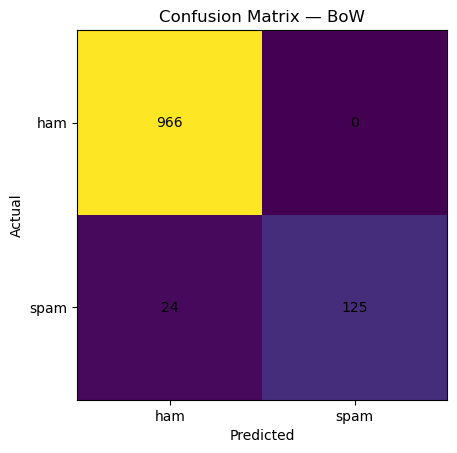

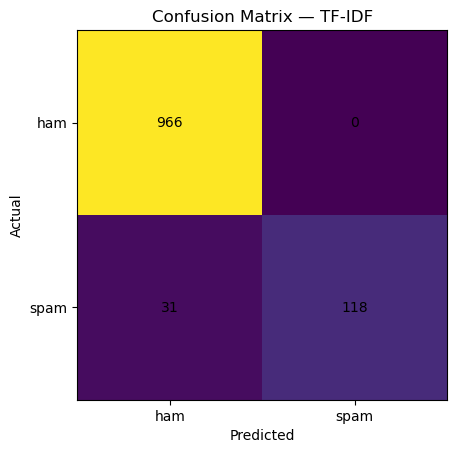

In [202]:
def plot_confusion_matrix(cm, title):
    labels = ["ham", "spam"]

    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xticks([0, 1], labels)
    plt.yticks([0, 1], labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            plt.text(col, row, str(cm[row, col]), ha="center", va="center")

    plt.show()

plot_confusion_matrix(bow_cm, "Confusion Matrix — BoW")
plot_confusion_matrix(tfidf_cm, "Confusion Matrix — TF-IDF")

## Compare results and reflections

In [205]:
print("BoW Accuracy  :", round(bow_acc, 4))
print("TF-IDF Accuracy:", round(tfidf_acc, 4))

if tfidf_acc > bow_acc:
    better = "TF-IDF"
elif bow_acc > tfidf_acc:
    better = "BoW"
else:
    better = "Tie"

print("\nBased on accuracy:", better)

BoW Accuracy  : 0.9785
TF-IDF Accuracy: 0.9722

Based on accuracy: BoW


In [207]:
# Q1) How does the accuracy compare?
# BoW did better, 0.9785 vs TF-IDF at 0.9722.
# This is not a massive gap, but BoW had the win.

# Q2) Which version handled messages better?
# Taking a looking at the confusion matrices helped more than accuracy only.
# Here both models had 0 false positives.
# The difference was missed spam:
# 1. BoW missed 24 spam messages
# 2. TF-IDF missed 31 spam messages
# BoW handled spam detection better, because it actually missed fewer spam texts.

# Q3) Which one would you prefer and why?
# Concerning the dataset, I chose BoW.
# Its is much simpler, more accuracy, it captured more spam concerning the results.
# TF-IDF is useful, but concerning this run it did not beat BoW.